# 1. Data:

## 1.1. Import Libraries

In [74]:
import numpy as np
import os
import glob
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import joblib
from google.colab import files
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

## 1.2. Read image from folder:
Mô tả: hàm này thực hiện đọc ảnh từ đường dẫn trên drive, sau đó lưu vào 2 list có tên image và label

In [71]:
def read_images_from_folder(folder_path):
    images = []
    labels = []
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        lst_img_path = glob.glob(os.path.join(class_path, "*.png"))
        for img_path in lst_img_path:
            img_path = os.path.join(class_path, img_path)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(class_name)
                #print(class_name)
    return np.array(images), np.array(labels)

In [ ]:
data, label = read_images_from_folder("/content/drive/MyDrive/Dataset/School AI-Project/augumented_dataset")

## 1.3. Process_image (resize, convert BGR image to RBG image, img_normalized)
- resize ảnh về kích thước 128 * 128 -> do có một số ảnh có kích thước rất nhỏ nên vì ở đây chúng ta đang giả sử thực hiện classify các object đã được detect.
- convert từ không gian màu BGR sang không gian màu RGB -> điều này là do các thư viện như matplotlib hoạt động ở không gian màu RGB
- Normalize ảnh
- Chuyển đầu ra sang mảng numpy

In [24]:
def process_image(images):
  processed_image = []
  for image in images:
    image = cv2.resize(image, (128,128))
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_normalized = img_rgb / 255.0
    processed_image.append(img_normalized)
  return np.array(processed_image)

In [25]:
data = process_image(data)

## 1.4. Encoding label (One hot encoder)
- Mô tả: hàm này thực hiện Encode ảnh bằng One-Hot-Encoding

In [27]:
def encode_labels(labels):
    encoder = OneHotEncoder(sparse=False)
    labels_encoded = encoder.fit_transform(labels.reshape(-1, 1))
    return labels_encoded

In [28]:
label = encode_labels(label)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## 1.6. Splitting Train - Test:
Mô tả: chia tập train-test với tỷ lệ 80-20

In [32]:
 X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

## 1.7. Reshape train size and test size for training
Mô tả: Reshape ảnh về dạng (n_samples, n_features) để phù hợp với yêu cầu của sklearn

In [36]:
n_samples, height, width, channels = X_train.shape
X_train = X_train.reshape((n_samples, height * width * channels))

In [40]:
n_samples, height, width, channels = X_test.shape
X_test = X_test.reshape((n_samples, height * width * channels))

# 2. Model

### 2.1. Training with KNN:

In [50]:
# training with knn:
acc_score = []
for i in range(1,40):
 knn = KNeighborsClassifier(n_neighbors=i,weights = 'distance')
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 acc_score.append(accuracy_score(y_test, pred_i))
 #acc_score.append(np.mean(pred_i != y_test))

## 2.2. Training with Decision Tree:

In [106]:
# training with decision tree
classifier = DecisionTreeClassifier(criterion="gini",
                                         max_depth=5, min_samples_leaf=10)
classifier.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)

## 2.3. Training with Random Forest:

In [63]:
# training with random forest:
sk_model = RandomForestClassifier()
sk_model.fit(X_train, y_train)
sk_preds = sk_model.predict(X_test)


0.8356643356643356

## 2.4. Visualize Decision Tree Model:

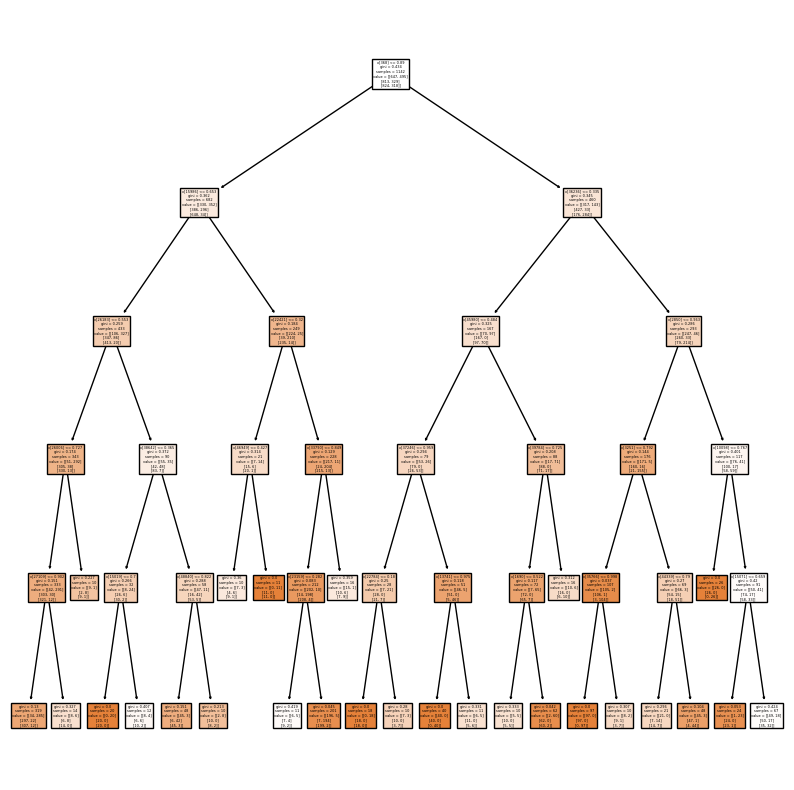

In [107]:
fig, ax = plt.subplots(figsize=(10,10))
plot_tree(classifier,ax=ax,filled=True)
plt.show()

## 2.5. Visualize Random Forest Model:

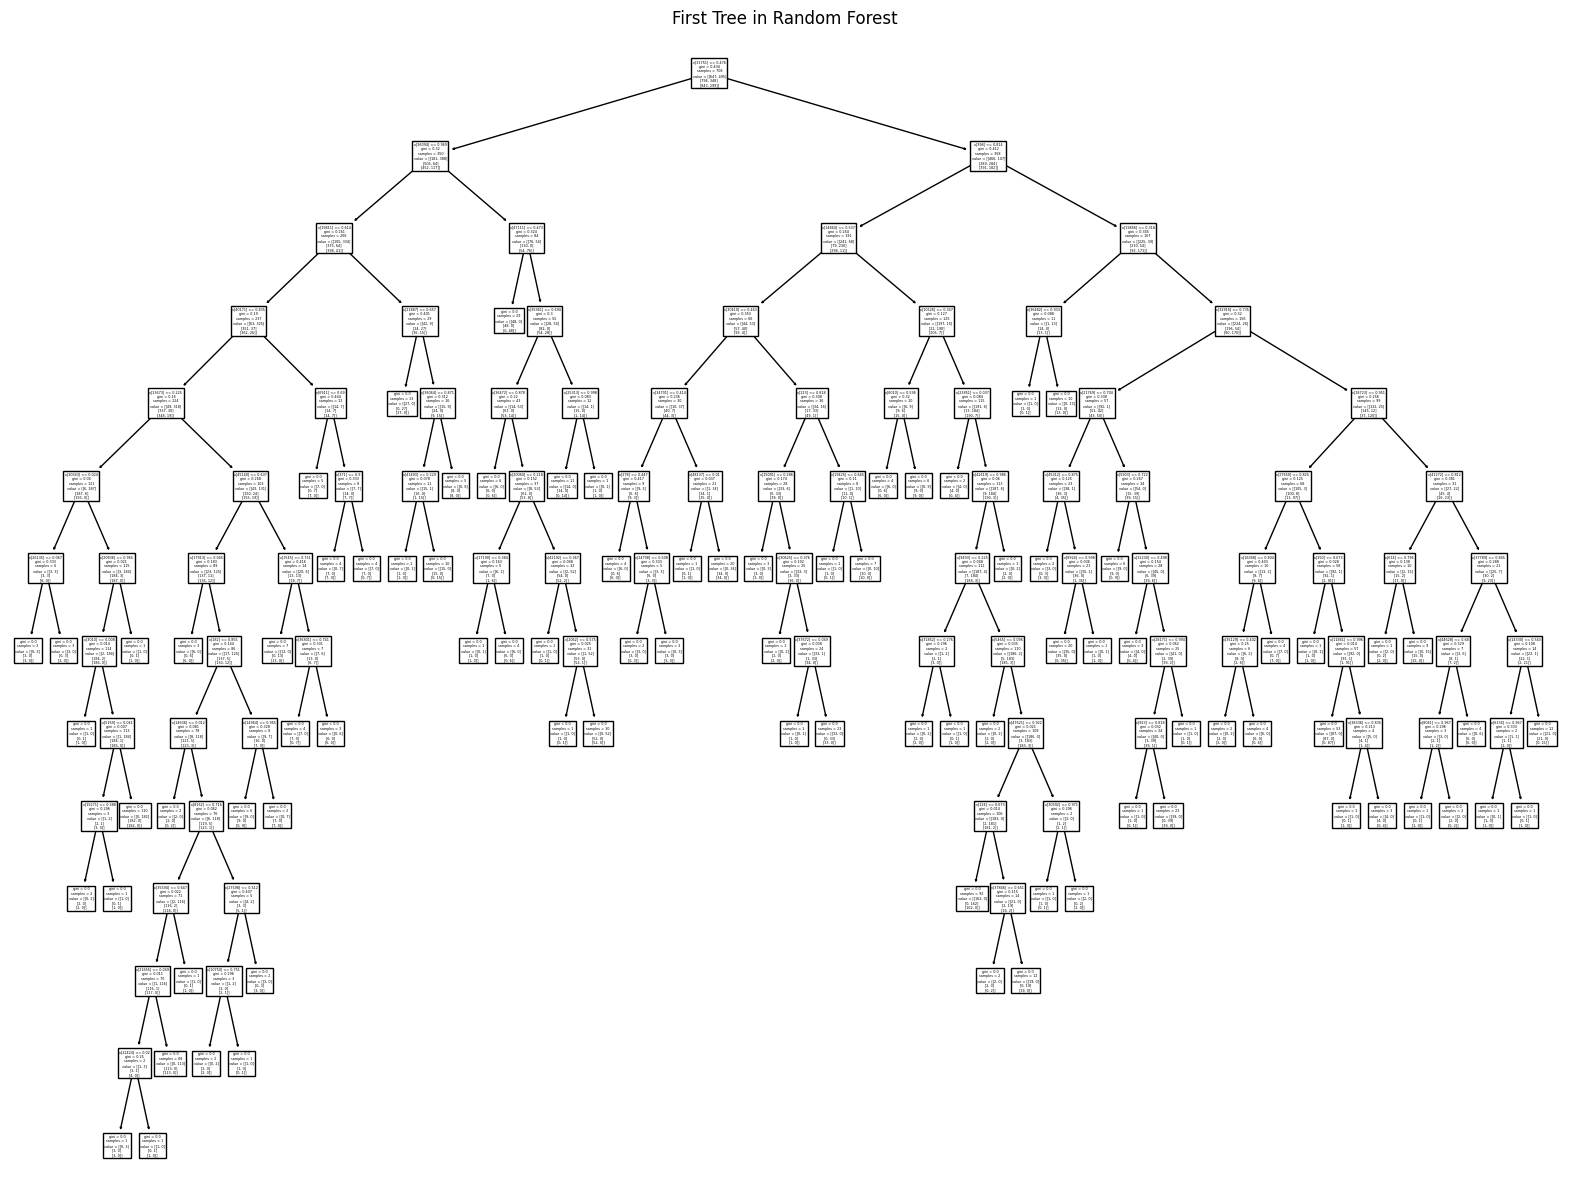

In [127]:
# Vẽ cây đầu tiên trong Random Forest
plt.figure(figsize=(20, 15))
plot_tree(sk_model.estimators_[0])
plt.title("First Tree in Random Forest")
plt.show()

# 3. Evaluation:

## 3.1. KNN:

Minimum accuracy: 0.7587412587412588 at K = 34
Maximum accuracy: 0.8391608391608392 at K = 9


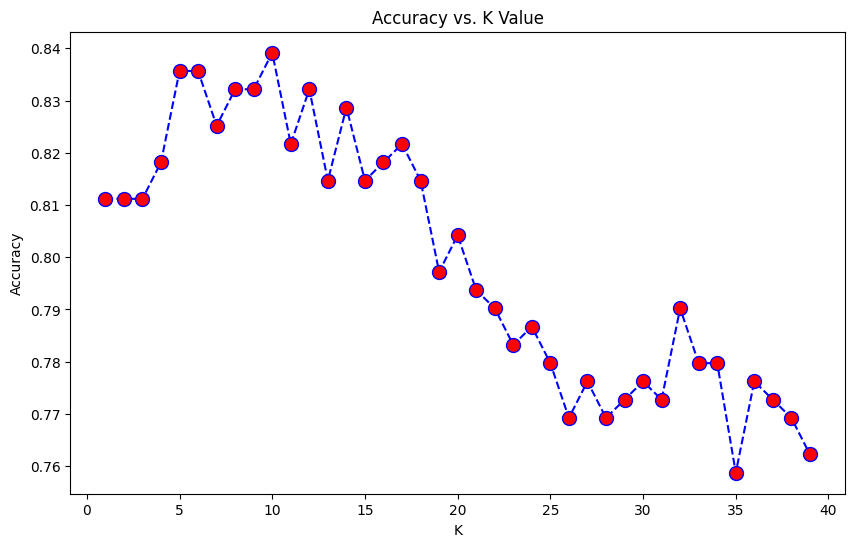

In [54]:
# visualize result in knn
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc_score,color='blue', linestyle='dashed',
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Minimum accuracy:",min(acc_score),"at K =",acc_score.index(min(acc_score)))
print("Maximum accuracy:",max(acc_score),"at K =",acc_score.index(max(acc_score)))

### 3.1.1 Evaluation with the best KNN (k=9)

In [75]:
knn_9 = KNeighborsClassifier(n_neighbors=9,weights = 'distance')
knn_9.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=9, weights='distance')

In [67]:
y_pred = knn_9.predict(X_test)

In [76]:
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

In [83]:
print(f"precision: {precision},\n recall: {recall},\n accuracy: {accuracy},\n f1 score: {f1}")

precision: [0.8968254  0.82051282 0.84722222],
 recall: [0.86259542 0.84210526 0.7721519 ],
 accuracy: 0.8321678321678322,
 f1 score: 0.8468359766368326


### 3.1.2. Visualize the evaluation of the best KNN (k=9)

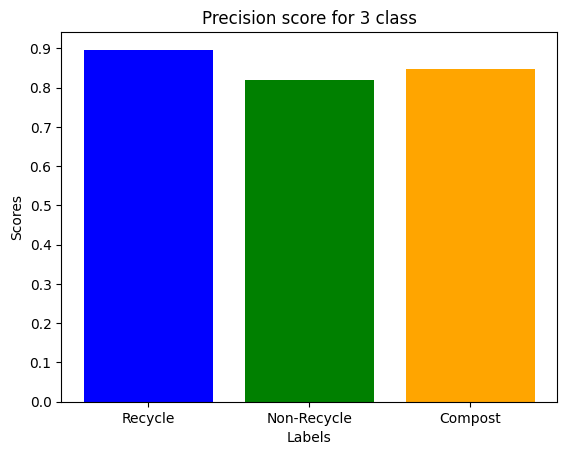

In [100]:
class_names = ["Recycle", "Non-Recycle", "Compost"]
colors = ["blue", "green", "orange"]
plt.bar(class_names, precision, color = colors)
plt.title("Precision score for 3 class")
plt.ylabel("Scores")
plt.xlabel("Labels")
plt.yticks(np.arange(0,1, 0.1))
plt.show()

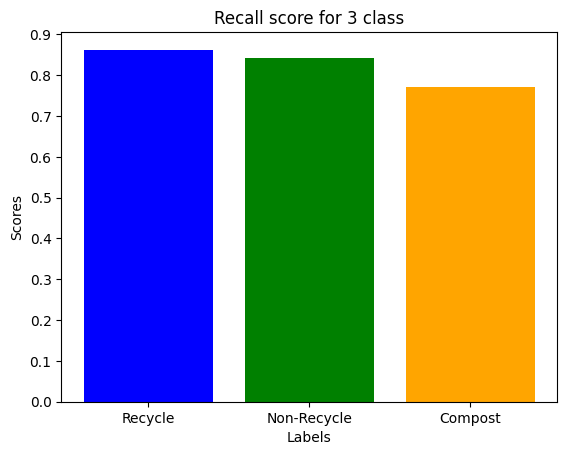

In [101]:
class_names = ["Recycle", "Non-Recycle", "Compost"]
plt.bar(class_names, recall, color = colors)
plt.title("Recall score for 3 class")
plt.ylabel("Scores")
plt.xlabel("Labels")
plt.yticks(np.arange(0,1, 0.1))
plt.show()

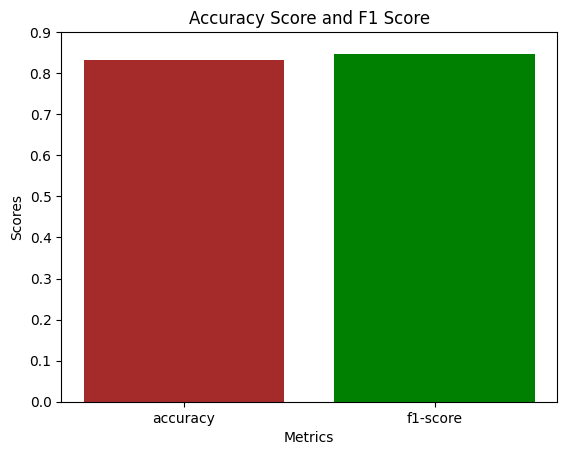

In [105]:
metrics_name = ["accuracy", "f1-score"]
value_metrics = [accuracy, f1]
colors = ["brown", "green"]
plt.bar(metrics_name, value_metrics, color = colors)
plt.title("Accuracy Score and F1 Score")
plt.yticks(np.arange(0,1,0.1))
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.show()

## 3.2. Decision Tree:

### 3.2.1. Evaluation with the best Decision Tree:

In [121]:
y_pred = classifier.predict(X_test)

In [122]:
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

In [123]:
print(f"precision: {precision},\n recall: {recall},\n accuracy: {accuracy},\n f1 score: {f1}")

precision: [0.83846154 0.76388889 0.75409836],
 recall: [0.83206107 0.72368421 0.58227848],
 accuracy: 0.7342657342657343,
 f1 score: 0.7616027857407168


### 3.2.2 Visualize the evaluation of the best Decision Tree:

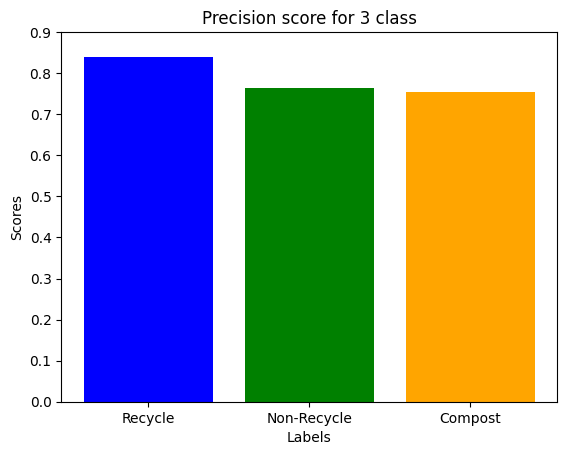

In [111]:
class_names = ["Recycle", "Non-Recycle", "Compost"]
colors = ["blue", "green", "orange"]
plt.bar(class_names, precision, color = colors)
plt.title("Precision score for 3 class")
plt.ylabel("Scores")
plt.xlabel("Labels")
plt.yticks(np.arange(0,1, 0.1))
plt.show()

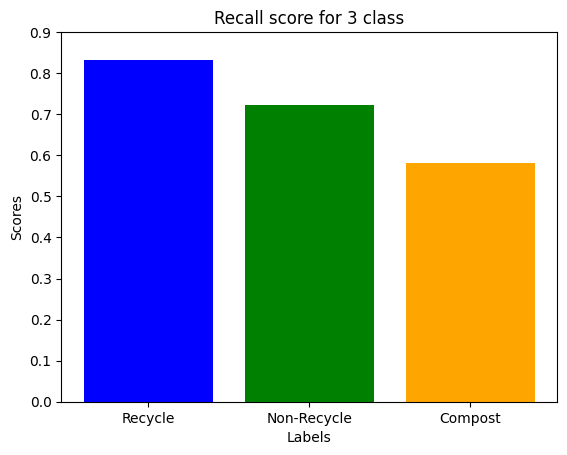

In [112]:
class_names = ["Recycle", "Non-Recycle", "Compost"]
plt.bar(class_names, recall, color = colors)
plt.title("Recall score for 3 class")
plt.ylabel("Scores")
plt.xlabel("Labels")
plt.yticks(np.arange(0,1, 0.1))
plt.show()

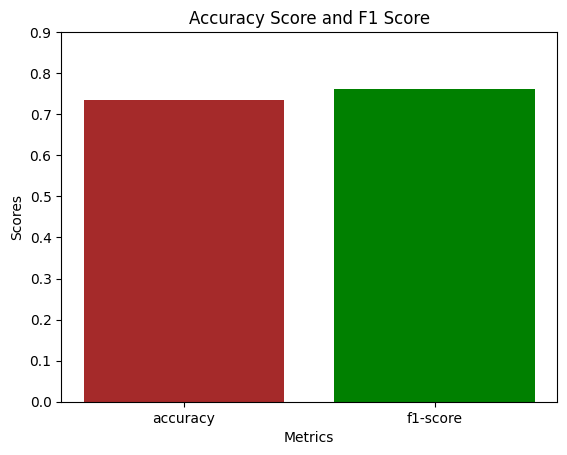

In [113]:
metrics_name = ["accuracy", "f1-score"]
value_metrics = [accuracy, f1]
colors = ["brown", "green"]
plt.bar(metrics_name, value_metrics, color = colors)
plt.title("Accuracy Score and F1 Score")
plt.yticks(np.arange(0,1,0.1))
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.show()

## 3.3. Random Forest:

### 3.3.1. Evaluation with the best Random Forest:

In [124]:
sk_preds = sk_model.predict(X_test)

In [125]:
precision = precision_score(y_test, sk_preds, average=None)
recall = recall_score(y_test,sk_preds, average=None)
accuracy = accuracy_score(y_test, sk_preds)
f1 = f1_score(y_test,sk_preds, average='weighted')

In [126]:
print(f"precision: {precision},\n recall: {recall},\n accuracy: {accuracy},\n f1 score: {f1}")

precision: [0.93442623 0.84722222 0.92753623],
 recall: [0.87022901 0.80263158 0.81012658],
 accuracy: 0.8356643356643356,
 f1 score: 0.8707283529417917


### 3.3.2. Visualize the evaluation of the best Random Forest

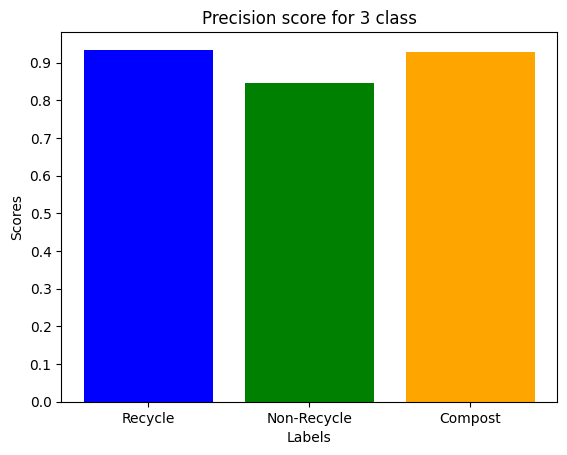

In [115]:
class_names = ["Recycle", "Non-Recycle", "Compost"]
colors = ["blue", "green", "orange"]
plt.bar(class_names, precision, color = colors)
plt.title("Precision score for 3 class")
plt.ylabel("Scores")
plt.xlabel("Labels")
plt.yticks(np.arange(0,1, 0.1))
plt.show()

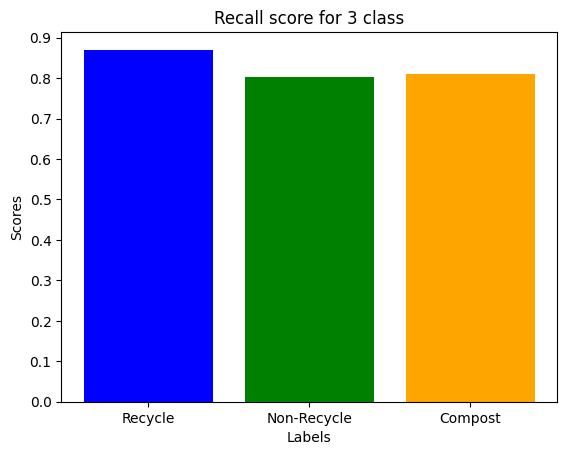

In [116]:
class_names = ["Recycle", "Non-Recycle", "Compost"]
plt.bar(class_names, recall, color = colors)
plt.title("Recall score for 3 class")
plt.ylabel("Scores")
plt.xlabel("Labels")
plt.yticks(np.arange(0,1, 0.1))
plt.show()

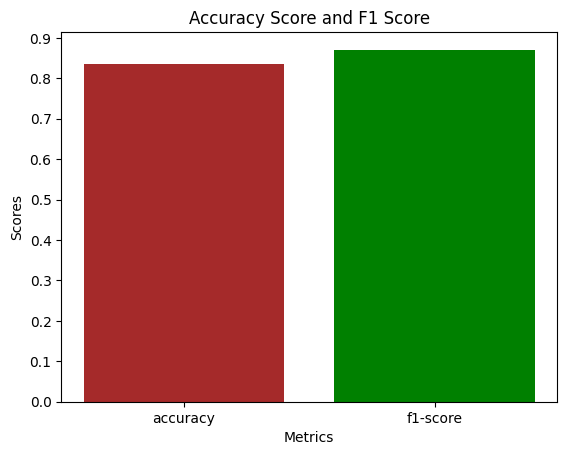

In [117]:
metrics_name = ["accuracy", "f1-score"]
value_metrics = [accuracy, f1]
colors = ["brown", "green"]
plt.bar(metrics_name, value_metrics, color = colors)
plt.title("Accuracy Score and F1 Score")
plt.yticks(np.arange(0,1,0.1))
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.show()